# Trotting behaviour
The purpose of this notebook is to train to move a policy that has learned to _stand_. 
It is the first step towards walking, and usually manifests with a policy that moves around dragging its feet (-> shuffling around) or that moves with little rythmic jumps (-> trotting).
In this case we have obtained the latter result, that we hope to refine into proper walking with the next notebook.
Again, we will provide a training and an evaluation section, along with the reward function and the "stand" policy

In [1]:
import time
import numpy as np
from stable_baselines3 import PPO

import sys
import os

# Start from the current working directory (where notebook is)
cwd = os.getcwd()

# Go two levels up (to the "grandparent")
grandparent_dir = os.path.abspath(os.path.join(cwd, "..", ".."))

# Add to sys.path if not already there
if grandparent_dir not in sys.path:
    sys.path.insert(0, grandparent_dir)

from SpotmicroEnv import SpotmicroEnv
from reward_function import reward_function, RewardState

pybullet build time: Apr  4 2025 18:56:19


# Training

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import configure

# ========= CONFIG ==========
TOTAL_STEPS = 12_000_000
run = "trot"
base="stand"

log_dir = f"./logs/{run}"

def clipped_linear_schedule(initial_value, min_value=1e-5):
    def schedule(progress_remaining):
        return max(progress_remaining * initial_value, min_value)
    return schedule

checkpoint_callback = CheckpointCallback(
    save_freq=TOTAL_STEPS // 12,
    save_path=f"{run}_checkpoints",
    name_prefix=f"ppo_{run}"
)

# ========= ENV ==========
env = SpotmicroEnv(
    use_gui=False,
    reward_fn=reward_function, 
    reward_state=RewardState(),
    src_save_file=f"{base}.pkl",
    dest_save_file=f"{run}.pkl"
)
check_env(env, warn=True)

# ========= MODEL ==========
model = PPO.load(f"ppo_{base}")
model.set_env(env)
model.tensorboard_log = log_dir

# Custom logger: ONLY csv + tensorboard (no stdout table)
new_logger = configure(log_dir, ["csv", "tensorboard"])
model.set_logger(new_logger)

In [2]:
%load_ext tensorboard
%tensorboard --logdir ./logs

In [ ]:
model.learn(
    total_timesteps=TOTAL_STEPS,
    reset_num_timesteps=False,
    callback=checkpoint_callback
)
model.save(f"ppo_{run}")
env.close()

# Evaluation

front_left_shoulder ha id: 2
front_left_leg ha id: 3
front_left_foot ha id: 5
front_right_shoulder ha id: 7
front_right_leg ha id: 8
front_right_foot ha id: 10
rear_left_shoulder ha id: 12
rear_left_leg ha id: 13
rear_left_foot ha id: 15
rear_right_shoulder ha id: 17
rear_right_leg ha id: 18
rear_right_foot ha id: 20
Terminated
dict_keys(['mean_abs_tau', 'rms_tau', 'max_tau', 'total_abs_torque', 'total_work', 'per_joint_mean', 'per_joint_max', 'episode_steps'])
Total work: 4571.495715798375
RMS torque: 5.147430537843053


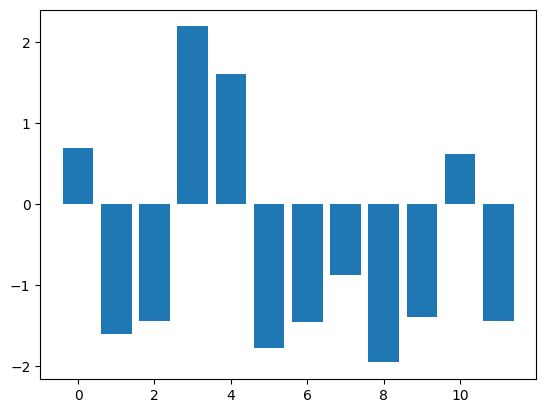

In [2]:
policy = "trot"

env = SpotmicroEnv(
    use_gui=True, 
    reward_fn=reward_function,
    reward_state=RewardState(),
    src_save_file=f"{policy}.pkl"
    )
obs, _ = env.reset()

# === Load model ===
#model = PPO.load(f"ppo_{policy}")
model = PPO.load(f"{policy}_checkpoints/ppo_{policy}_14001216_steps")

# === Run rollout ===
for _ in range(3001):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print("Terminated")
        env.plot_reward_components()
        obs, _ = env.reset()
    time.sleep(1/60)

env.close()